# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

16:51:29 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=217502;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=662270;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=945808;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=343612;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

<Table length=1>
    name        ra     dec    trigger_time   t90  
   object    float64 float64    float64    float64
------------ ------- ------- ------------- -------
GRB080916009 119.800 -56.600 54725.0088613  62.977

To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

16:52:28 INFO      Auto-determined polynomial order: 0                                ]8;id=480661;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=889856;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

16:52:38 INFO      None 0-order polynomial fit with the mle method                               ]8;id=525131;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=456281;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=64598;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=606656;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=34778;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=511823;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=830773;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=178134;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=559067;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=430368;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=435329;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=97993;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=966014;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=518141;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=286941;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=974367;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=564494;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=708069;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

16:52:40 INFO      Now using 120 bins                                                          ]8;id=976876;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=726661;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

16:52:42 INFO      Auto-determined polynomial order: 1                                ]8;id=184343;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=826682;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

16:52:52 INFO      None 1-order polynomial fit with the mle method                               ]8;id=407709;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=446865;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=877230;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=497461;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=941662;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=519976;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

16:52:53 INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=506800;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=871182;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=141168;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=217962;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=714915;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=313136;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=568894;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=857512;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=306363;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=407330;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=991372;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=502582;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=433991;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=259282;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

16:52:55 INFO      Auto-determined polynomial order: 1                                ]8;id=856700;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=665315;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

16:53:05 INFO      None 1-order polynomial fit with the mle method                               ]8;id=397701;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=434214;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=292758;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=956133;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=171174;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=4032;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=204190;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=976589;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=649555;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=302620;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

16:53:06 INFO      Auto-probed noise models:                                                    ]8;id=809119;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=45757;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=582973;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=483910;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=261009;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=922460;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=343002;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=516856;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=410801;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=6336;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

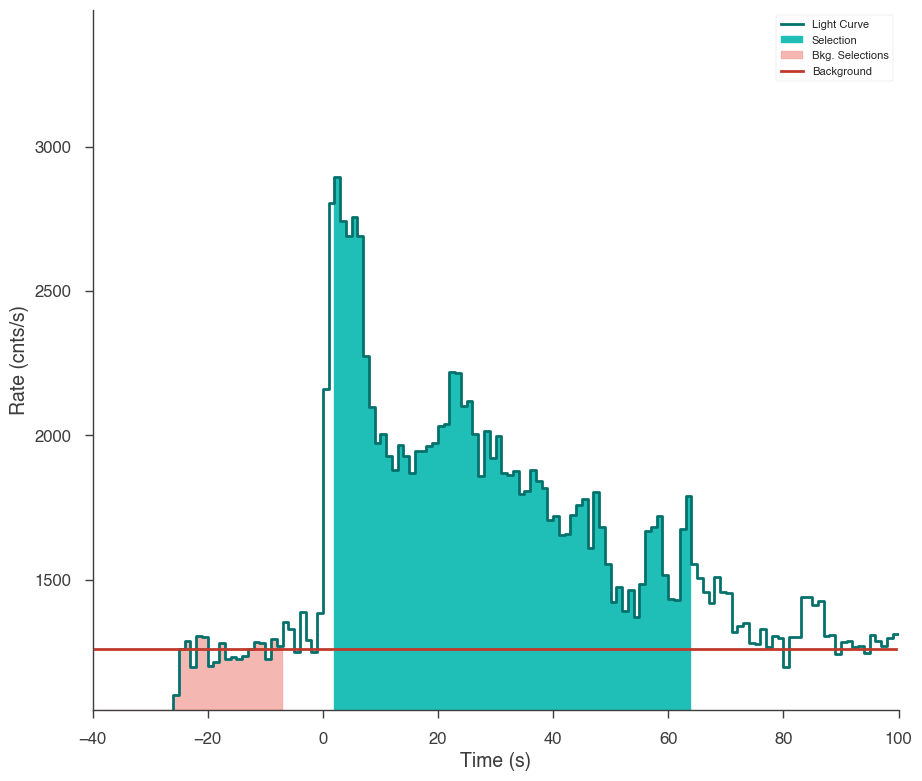

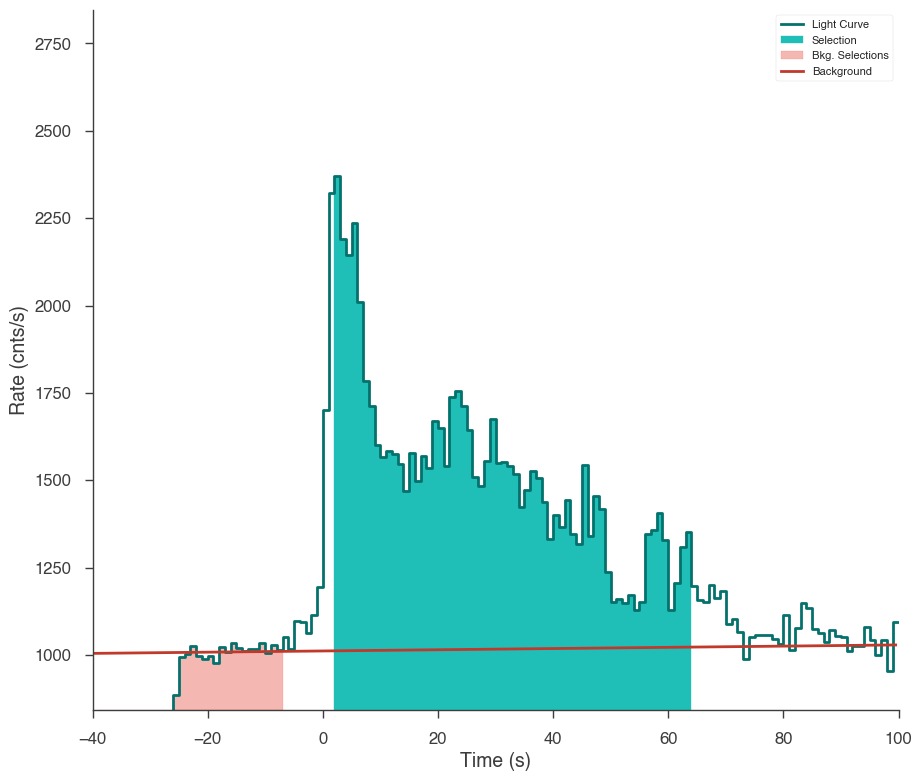

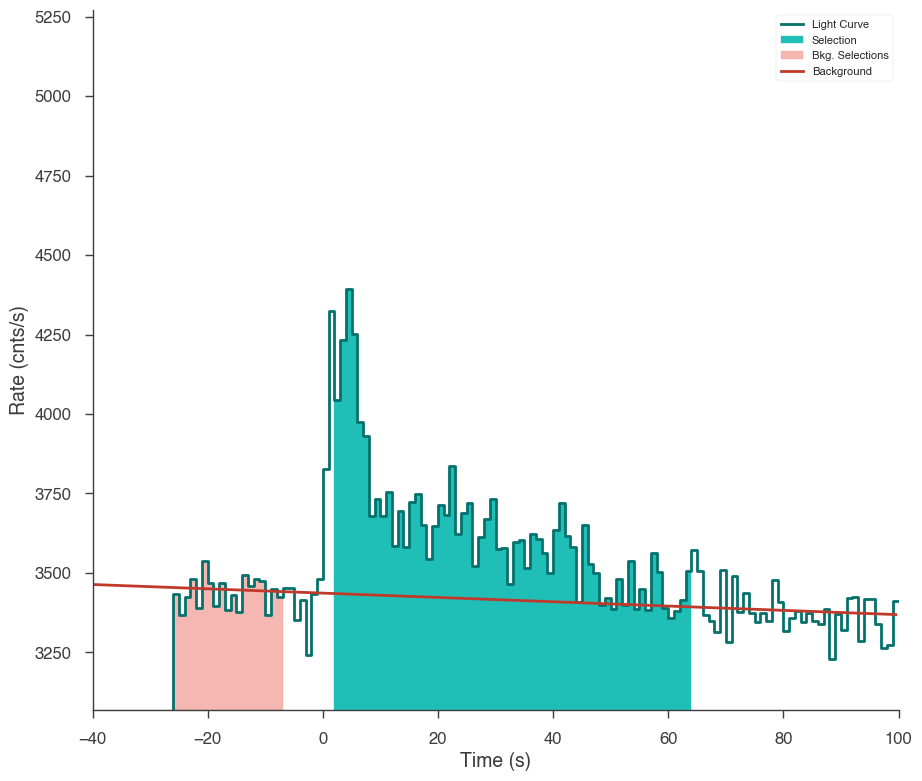

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:
    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):
        fluence_plugin.set_active_measurements("250-30000")

    else:
        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

         INFO      sampler set to multinest                                                ]8;id=453771;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=756278;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

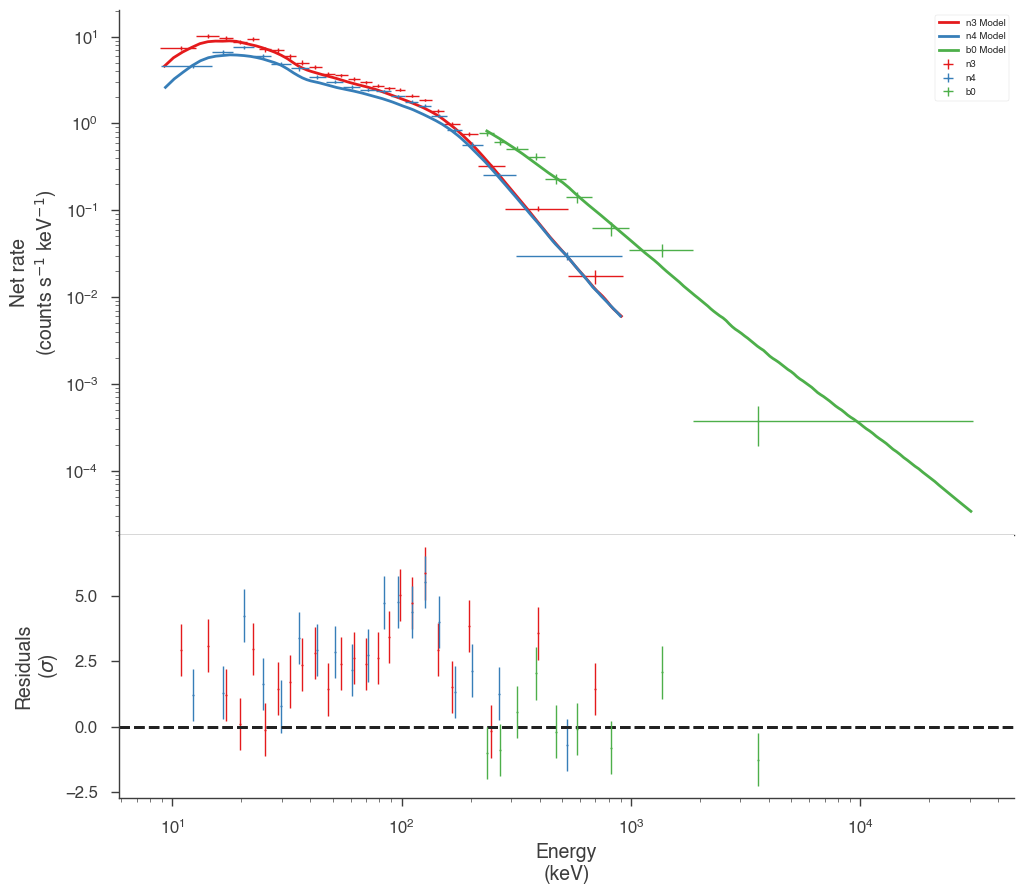

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3101.2662971946629      +/-  0.22457481206876856     
 Total Likelihood Evaluations:        24635
 Sampling finished. Exiting MultiNest



16:53:22 INFO      fit restored to maximum of posterior                                         ]8;id=945380;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=694607;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=374745;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=187419;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
GRB080916009...K             (1.460 -0.007 +0.028) x 10^-2  1 / (cm2 keV s)
GRB080916009...alpha                  -1.089 -0.004 +0.033                 
GRB080916009...break_energy       (1.86 +0.14 +0.7) x 10^2              keV
GRB080916009...break_scale         (0.0 +1.6 +3.3) x 10^-1                 
GRB080916009...beta                      -1.96 -0.23 -0.04

Values of -log(posterior) at the minimum:

-log(posterior)
b0        -1049.493734
n3        -1019.254414
n4        -1010.771384
total     -3079.519533

Values of statistical measures:

statistical measures
AIC              6169.209520
BIC              6188.441730
DIC              6179.834017
PDIC                4.349460
log(Z)          -1346.862840

Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=64701;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=98606;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

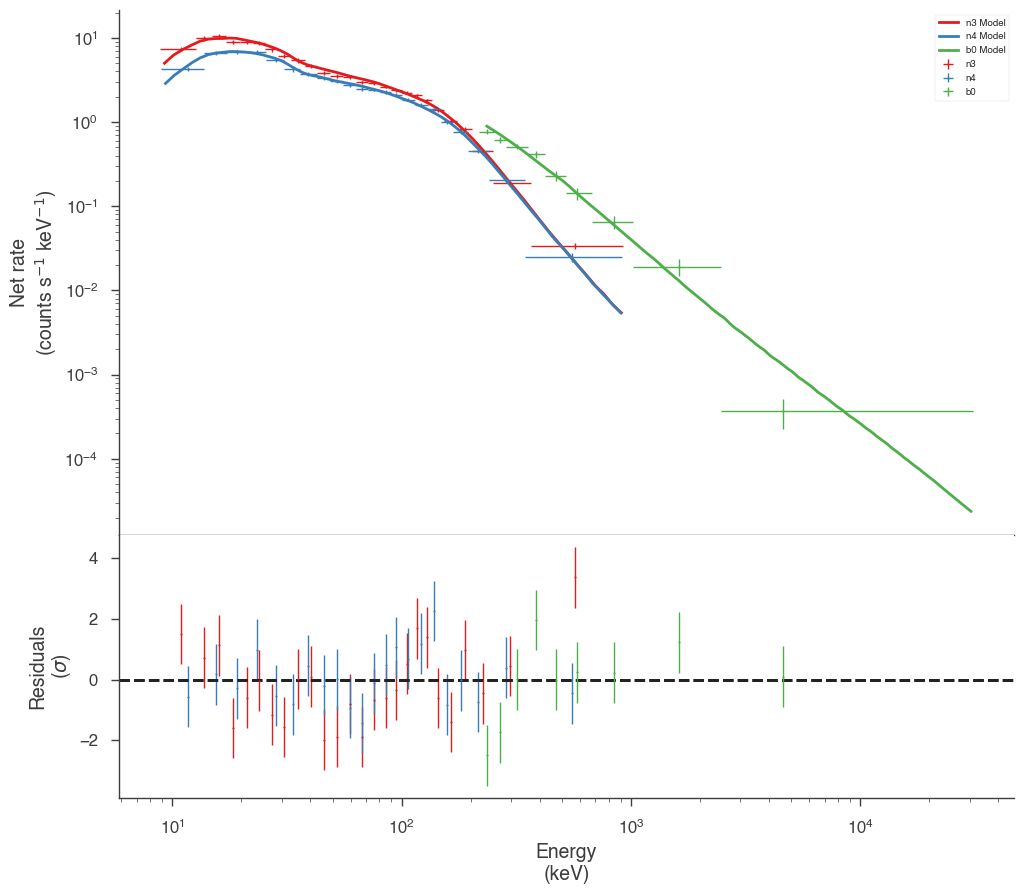

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

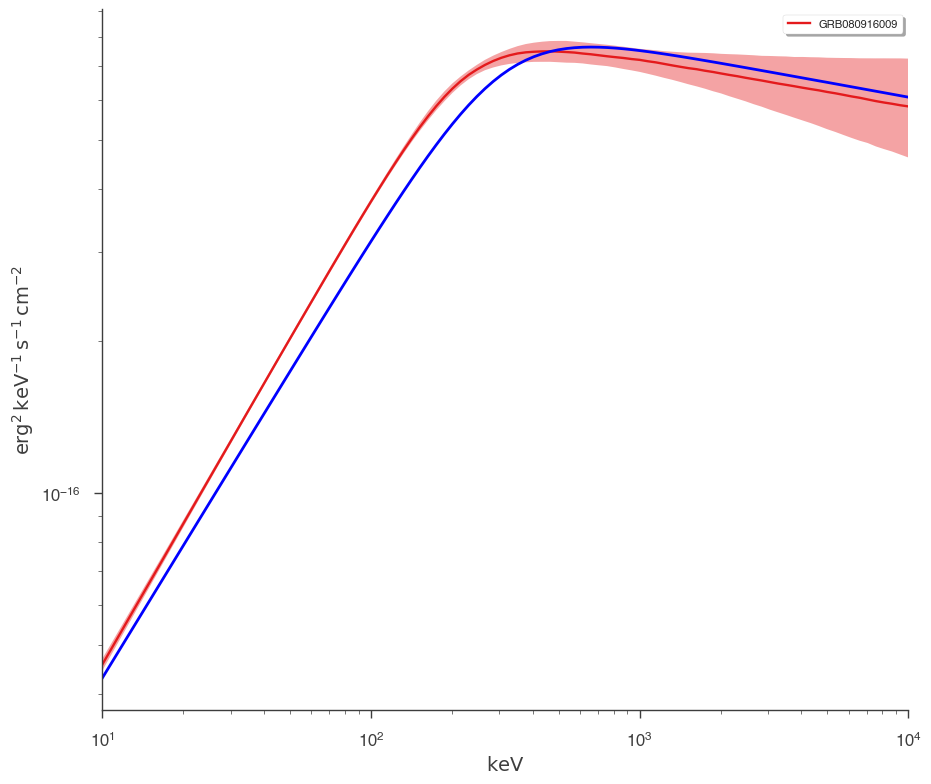

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

16:55:07 INFO      Created 15 bins via bayesblocks                                       ]8;id=209572;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=16652;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


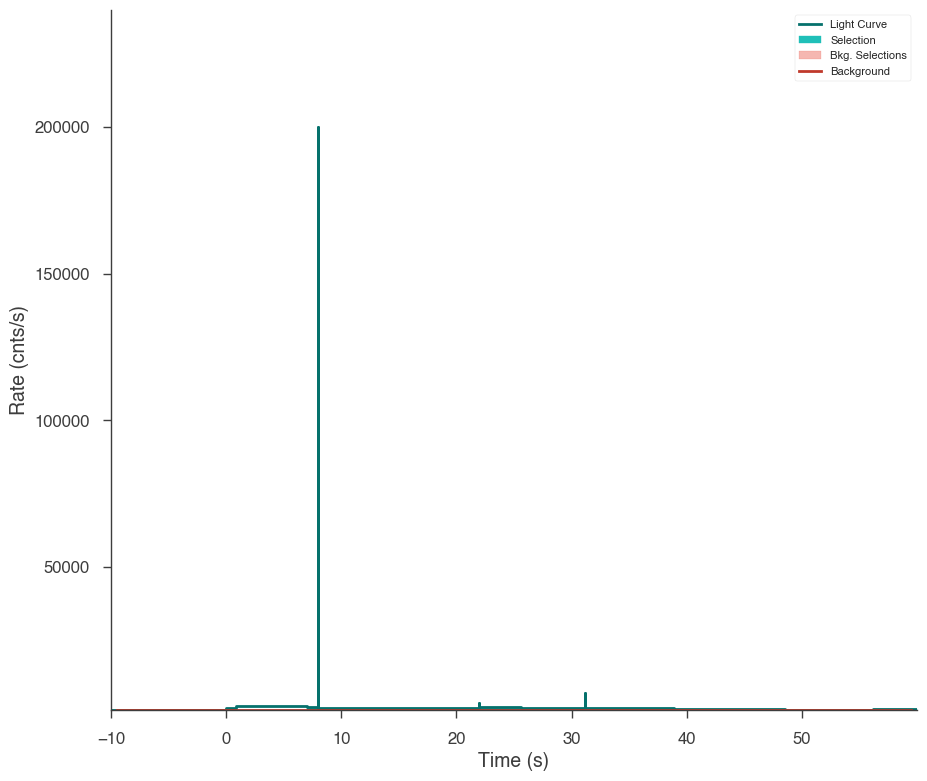

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):
    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):
    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

         INFO      Created 12 bins via custom                                            ]8;id=612885;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=110668;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

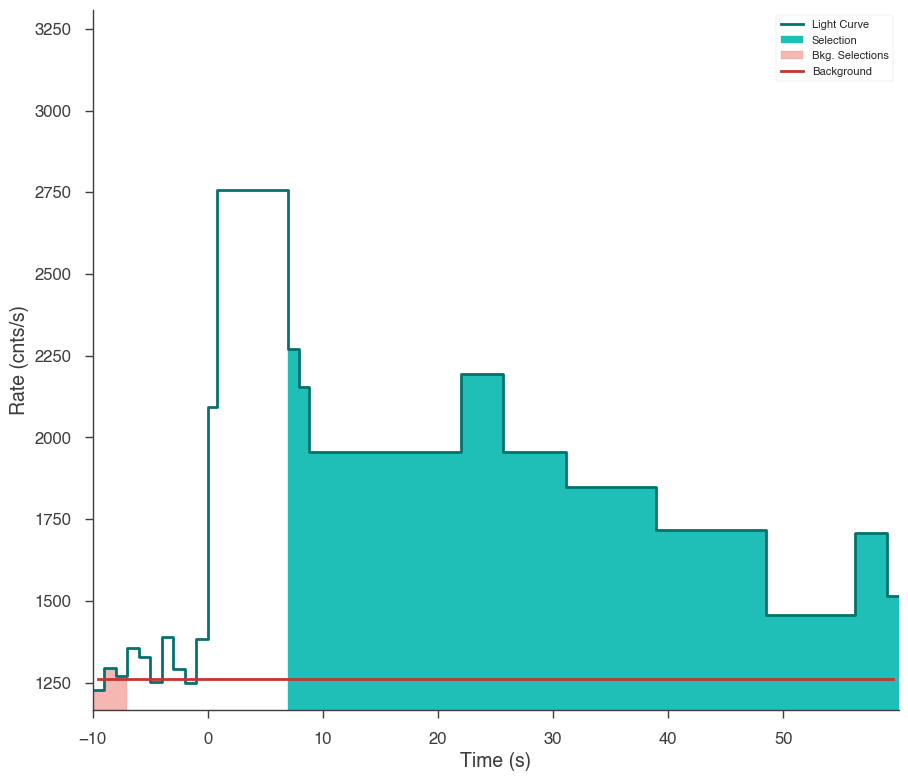

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=442402;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=423393;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

16:55:08 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=818405;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=848539;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=366936;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=446947;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=390600;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=820678;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=553825;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=649126;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

16:55:09 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=212807;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=677787;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (None, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):
    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():
        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=781646;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=149196;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=325500;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=43800;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=712130;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=699959;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=202016;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=473647;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=593854;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=809812;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 107 bins                                                          ]8;id=395324;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=853394;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=894875;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=365435;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -790.90164661126732      +/-  0.18489667352987210     
 Total Likelihood Evaluations:        17373
 Sampling finished. Exiting MultiNest



16:55:21 INFO      fit restored to maximum of posterior                                         ]8;id=296249;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=400180;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=1006;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=345759;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (3.71 -0.19 +1.1) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-5.3 -0.7 +1.2) x 10^-1                 
grb.spectrum.main.Band.xp      (3.00 -0.7 +0.09) x 10^2              keV
grb.spectrum.main.Band.beta         -2.003 +0.030 +0.22

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval0      -285.646184
n3_interval0      -250.049918
n4_interval0      -267.894831
total             -803.590933

Values of statistical measures:

statistical measures
AIC              1615.295180
BIC              1630.703998
DIC              1570.423813
PDIC                2.096902
log(Z)           -343.484221

16:55:22 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=463676;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=151918;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=868121;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=644843;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=730640;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=148979;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=854419;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=61478;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=461971;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=792925;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=10415;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=987027;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=142264;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=897836;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1967.6040802057221      +/-  0.21945192080912959     
 Total Likelihood Evaluations:        21639
 Sampling finished. Exiting MultiNest



16:55:36 INFO      fit restored to maximum of posterior                                         ]8;id=779837;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=172877;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=460360;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=538938;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                    
grb.spectrum.main.Band.K      (5.4728 +0.0008 +0.12) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha     (-6.52 -0.08 +0.18) x 10^-1                 
grb.spectrum.main.Band.xp      (3.6035 -0.15 +0.0034) x 10^2              keV
grb.spectrum.main.Band.beta              -1.915 -0.016 +0.05

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval1      -682.590781
n3_interval1      -648.446755
n4_interval1      -645.419554
total            -1976.457090

Values of statistical measures:

statistical measures
AIC              3961.027495
BIC              3976.436312
DIC              3913.414700
PDIC                2.948285
log(Z)           -854.519595

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=309507;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=560186;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=921346;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=151055;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=561633;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=130066;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=473500;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=88788;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=267540;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=199618;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 115 bins                                                          ]8;id=949568;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=732582;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=888292;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=942701;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -907.42089066173651      +/-  0.19577100808718526     
 Total Likelihood Evaluations:        20441
 Sampling finished. Exiting MultiNest



16:55:49 INFO      fit restored to maximum of posterior                                         ]8;id=938430;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=141493;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=977628;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=658864;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.52 -0.08 +0.31) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.06 -0.04 +0.06                 
grb.spectrum.main.Band.xp         (5.9 -1.9 +0.6) x 10^2              keV
grb.spectrum.main.Band.beta            -1.87 +0.04 +0.17

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval2      -324.532977
n3_interval2      -289.190446
n4_interval2      -312.304033
total             -926.027457

Values of statistical measures:

statistical measures
AIC              1860.168228
BIC              1875.577045
DIC              1803.824895
PDIC                1.978382
log(Z)           -394.087886

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=398064;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=638597;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=643314;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=884400;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=803596;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=723689;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=592428;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=424669;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=907180;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=960054;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 109 bins                                                          ]8;id=584889;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=621427;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=426754;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=911789;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.01067851739185      +/-  0.17597589965091365     
 Total Likelihood Evaluations:        16353
 Sampling finished. Exiting MultiNest



16:55:59 INFO      fit restored to maximum of posterior                                         ]8;id=335038;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=634967;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=954728;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=199043;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (2.85 -0.26 +0.4) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-9.3 -0.8 +1.0) x 10^-1                 
grb.spectrum.main.Band.xp        (3.5 -0.6 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta            -2.29 -0.4 +0.20

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval3      -298.486130
n3_interval3      -242.625875
n4_interval3      -262.611922
total             -803.723927

Values of statistical measures:

statistical measures
AIC              1615.561169
BIC              1630.969986
DIC              1570.722009
PDIC                3.079172
log(Z)           -342.228689

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=412271;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=870999;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=284365;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=637657;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=803187;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=787737;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=687942;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=550831;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=988051;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=126461;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=777186;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=402723;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=271472;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=150690;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt
 ln(ev)=  -2270.9239163761731      +/-  0.19965667908676243     
 Total Likelihood Evaluations:        19500
 Sampling finished. Exiting MultiNest


16:56:11 INFO      fit restored to maximum of posterior                                         ]8;id=569540;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=946095;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=583213;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=498847;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.03 -0.09 +0.13) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-9.88 -0.31 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp           (4.0 +/- 0.5) x 10^2              keV
grb.spectrum.main.Band.beta            -1.95 -0.11 +0.05

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval4      -778.539006
n3_interval4      -756.937012
n4_interval4      -746.970960
total            -2282.446979

Values of statistical measures:

statistical measures
AIC              4573.007272
BIC              4588.416090
DIC              4527.603372
PDIC                3.379835
log(Z)           -986.249726

16:56:12 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=380329;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=612291;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=651892;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=631956;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=901413;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=745157;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=690729;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=200219;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=566183;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=986922;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=925629;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=906159;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=510089;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=395330;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1573.1781642844931      +/-  0.19206541008991257     
 Total Likelihood Evaluations:        20405
 Sampling finished. Exiting MultiNest



16:56:24 INFO      fit restored to maximum of posterior                                         ]8;id=903786;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=547505;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=325962;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=412256;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (2.79 +/- 0.18) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-9.1 -0.6 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp       (4.2 -0.4 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta          -2.10 -0.26 +0.07

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval5      -536.787450
n3_interval5      -523.629326
n4_interval5      -527.563861
total            -1587.980638

Values of statistical measures:

statistical measures
AIC              3184.074589
BIC              3199.483407
DIC              3136.572348
PDIC                3.358893
log(Z)           -683.222596

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=503030;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=633620;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=769595;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=187994;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=699837;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=950033;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=878126;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=446797;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=752706;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=86758;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=358523;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=747085;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=153596;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=765924;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1754.8010187096127      +/-  0.19015693436963355     
 Total Likelihood Evaluations:        21232
 Sampling finished. Exiting MultiNest



16:56:37 INFO      fit restored to maximum of posterior                                         ]8;id=433436;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=368775;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=598983;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=904295;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.95 -0.13 +0.12) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.01 -0.05 +0.04                 
grb.spectrum.main.Band.xp         (4.5 -0.5 +0.9) x 10^2              keV
grb.spectrum.main.Band.beta             -2.35 -0.4 +0.15

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval6      -609.541299
n3_interval6      -584.288412
n4_interval6      -576.833231
total            -1770.662942

Values of statistical measures:

statistical measures
AIC              3549.439198
BIC              3564.848015
DIC              3501.544959
PDIC                3.502718
log(Z)           -762.100399

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=563885;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=586951;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=95501;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=521928;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=685756;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=402924;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=806694;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=497939;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=608275;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=820207;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=300002;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=525150;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=149536;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=216911;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1944.5883838058355      +/-  0.20240179262336955     
 Total Likelihood Evaluations:        19245
 Sampling finished. Exiting MultiNest



16:56:52 INFO      fit restored to maximum of posterior                                         ]8;id=641830;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=337827;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=117882;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=910126;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.72 -0.07 +0.12) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha         -1.042 -0.019 +0.05                 
grb.spectrum.main.Band.xp       (4.00 -0.7 +0.14) x 10^2              keV
grb.spectrum.main.Band.beta          -1.989 +0.028 +0.12

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval7      -663.508849
n3_interval7      -641.274348
n4_interval7      -649.360187
total            -1954.143384

Values of statistical measures:

statistical measures
AIC              3916.400082
BIC              3931.808899
DIC              3871.979929
PDIC                2.792304
log(Z)           -844.524005

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=527488;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=901393;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=551768;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=576363;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=375289;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=225853;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=612924;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=298033;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=706803;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=37315;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=882708;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=564867;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=172322;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=676111;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2054.5099453717667      +/-  0.19392444568059933     
 Total Likelihood Evaluations:        18998
 Sampling finished. Exiting MultiNest



16:57:06 INFO      fit restored to maximum of posterior                                         ]8;id=500840;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=31563;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=235758;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=901594;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.54 -0.12 +0.05) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.45 -0.6 +0.28) x 10^-1                 
grb.spectrum.main.Band.xp       (3.65 -0.12 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta          -2.381 -0.33 -0.020

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval8      -701.749995
n3_interval8      -698.541194
n4_interval8      -666.799047
total            -2067.090235

Values of statistical measures:

statistical measures
AIC              4142.293784
BIC              4157.702602
DIC              4096.587563
PDIC                2.286554
log(Z)           -892.262332

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=725994;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=187314;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=953504;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=806940;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=493899;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=63938;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=950564;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=108172;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=603155;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=460820;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=563655;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=658807;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=305192;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=442246;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1879.2285639083673      +/-  0.14856986674090070     
 Total Likelihood Evaluations:        12131
 Sampling finished. Exiting MultiNest



16:57:15 INFO      fit restored to maximum of posterior                                         ]8;id=494116;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=696728;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=721247;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=792640;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (1.2 -0.4 +1.5) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.4 -2.0 +3.5) x 10^-1                 
grb.spectrum.main.Band.xp         (1.1 +/- 0.5) x 10^2              keV
grb.spectrum.main.Band.beta           -1.85 -0.4 +0.14

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval9      -648.555965
n3_interval9      -617.000573
n4_interval9      -616.172080
total            -1881.728618

Values of statistical measures:

statistical measures
AIC              3771.570550
BIC              3786.979368
DIC              3693.050858
PDIC              -53.920988
log(Z)           -816.138596

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=157432;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=132316;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=776508;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=989794;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=769016;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=590186;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=916817;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=183897;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=234074;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=442813;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=371460;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=584867;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=638904;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=550879;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1323.1767354254173      +/-  0.17027620704030610     
 Total Likelihood Evaluations:        14850
 Sampling finished. Exiting MultiNest



16:57:26 INFO      fit restored to maximum of posterior                                         ]8;id=615299;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=403278;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=647720;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=843820;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                 
grb.spectrum.main.Band.K      (2.058 +0.018 +1.1) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-7.39 +0.04 +2.6) x 10^-1                 
grb.spectrum.main.Band.xp        (2.16 -0.7 +0.04) x 10^2              keV
grb.spectrum.main.Band.beta             -1.94 -0.18 +0.13

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval10      -460.853643
n3_interval10      -437.666964
n4_interval10      -433.121041
total             -1331.641648

Values of statistical measures:

statistical measures
AIC              2671.396611
BIC              2686.805428
DIC              2634.051537
PDIC                0.565545
log(Z)           -574.648355

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=337898;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=825098;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=752994;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=573533;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=203483;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=134383;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=230224;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=90034;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=823966;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=525817;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=911872;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=685378;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=477340;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=577788;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -812.29989169691828      +/-  0.14890684634461493     
 Total Likelihood Evaluations:        12561
 Sampling finished. Exiting MultiNest



16:57:35 INFO      fit restored to maximum of posterior                                         ]8;id=120425;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=907055;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=522798;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=450802;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K        (2.9 -0.8 +2.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha     (-4.7 -2.0 +4) x 10^-1                 
grb.spectrum.main.Band.xp     (1.26 -0.30 +0.22) x 10^2              keV
grb.spectrum.main.Band.beta           -2.17 -0.10 +0.29

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval11      -292.423428
n3_interval11      -272.447417
n4_interval11      -255.820773
total              -820.691618

Values of statistical measures:

statistical measures
AIC              1649.496550
BIC              1664.905367
DIC              1615.154151
PDIC               -1.669928
log(Z)           -352.777361

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=515280;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=470439;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:57:36 INFO      fit restored to median of posterior                                          ]8;id=580462;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=464489;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:57:37 INFO      fit restored to median of posterior                                          ]8;id=920572;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=275300;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:57:38 INFO      fit restored to median of posterior                                          ]8;id=609858;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=602841;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=562907;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=740045;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:57:39 INFO      fit restored to median of posterior                                          ]8;id=976742;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=820943;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:57:40 INFO      fit restored to median of posterior                                          ]8;id=183386;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=692411;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:57:41 INFO      fit restored to median of posterior                                          ]8;id=129208;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=134461;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:57:42 INFO      fit restored to median of posterior                                          ]8;id=113109;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=252583;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=839134;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=824554;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:57:43 INFO      fit restored to median of posterior                                          ]8;id=481797;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=832897;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:57:44 INFO      fit restored to median of posterior                                          ]8;id=156205;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=49002;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

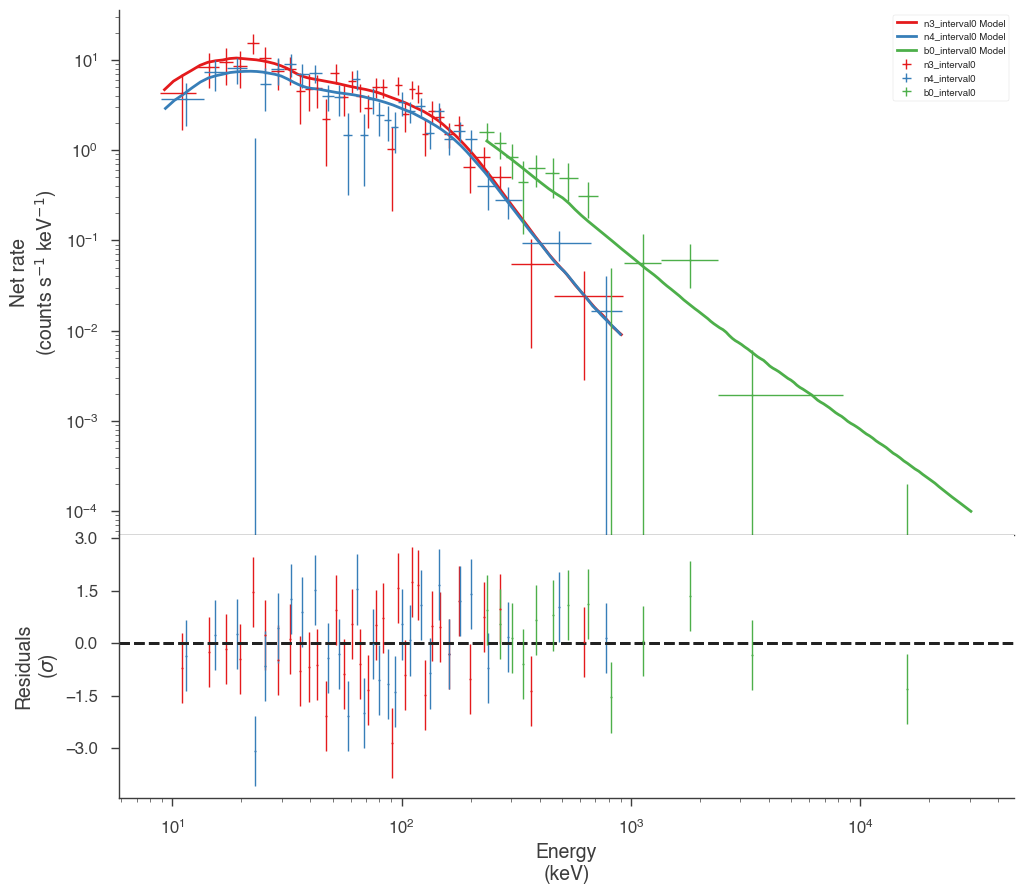

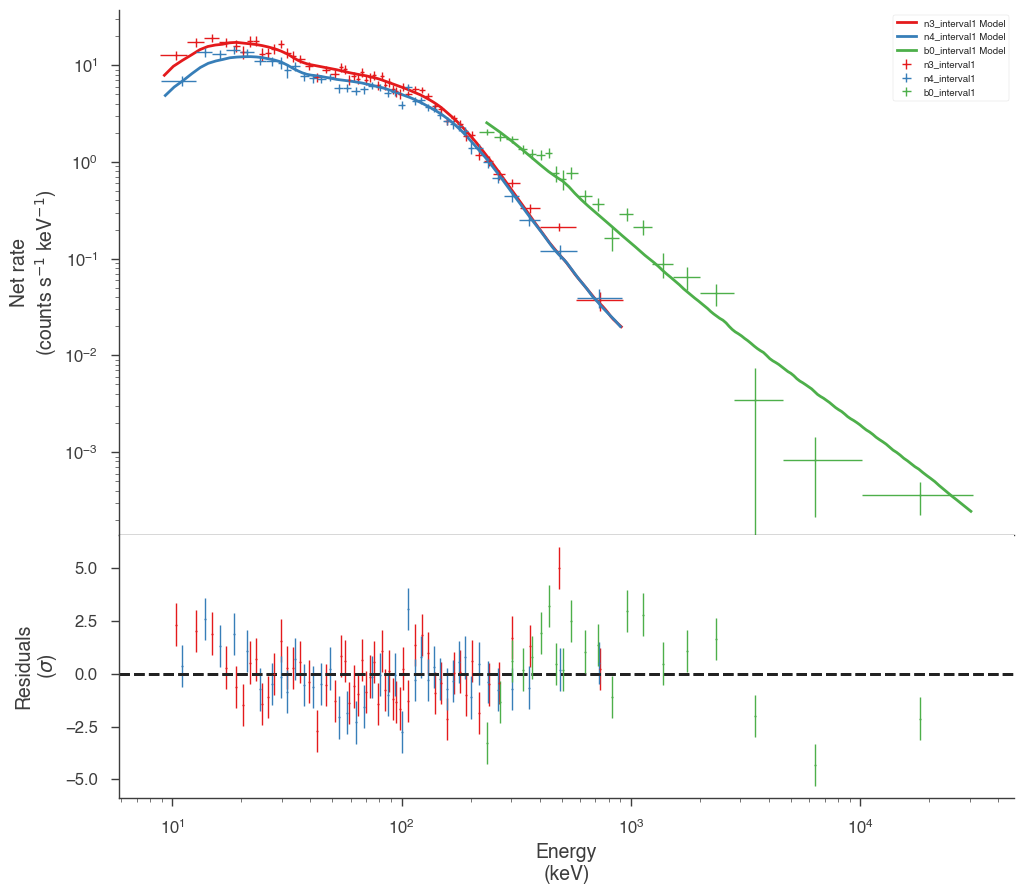

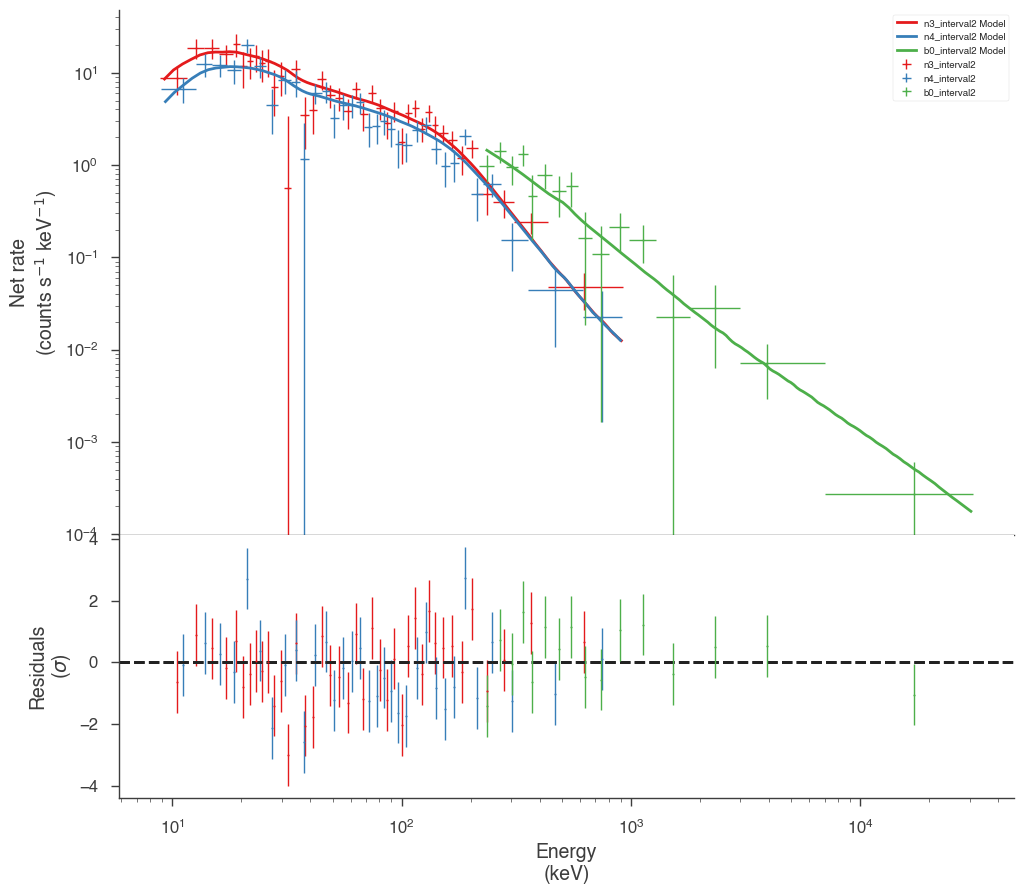

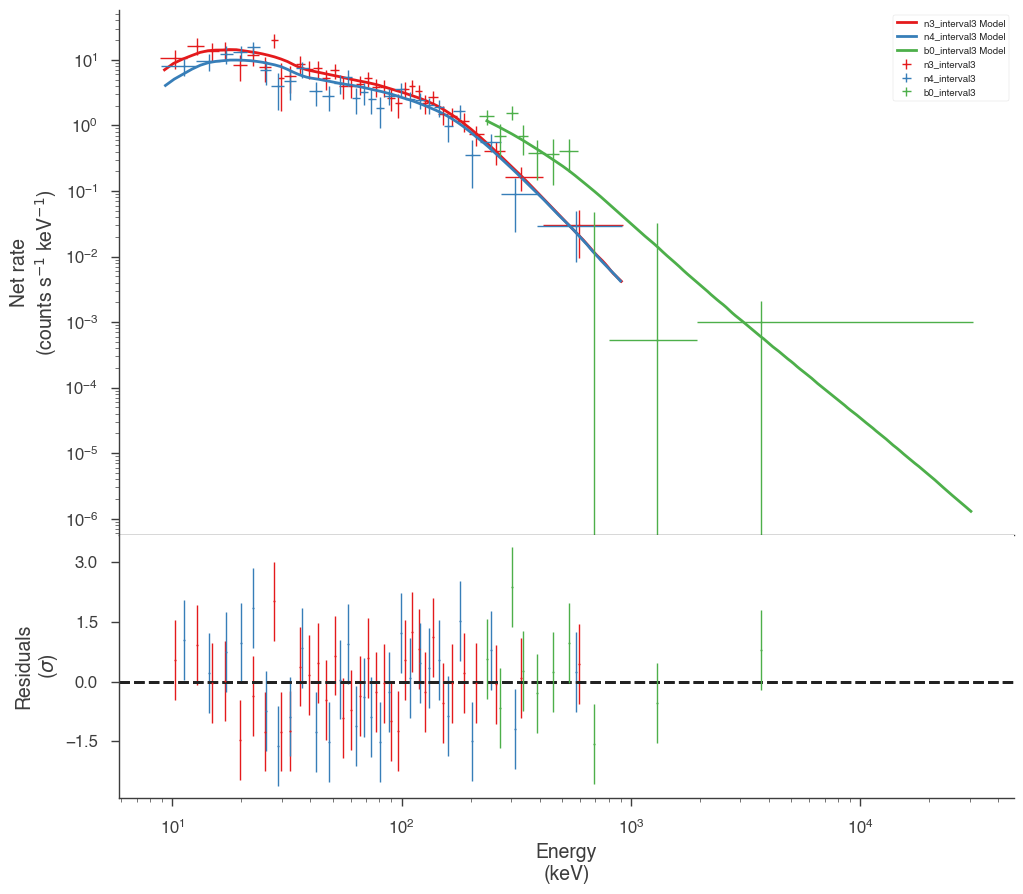

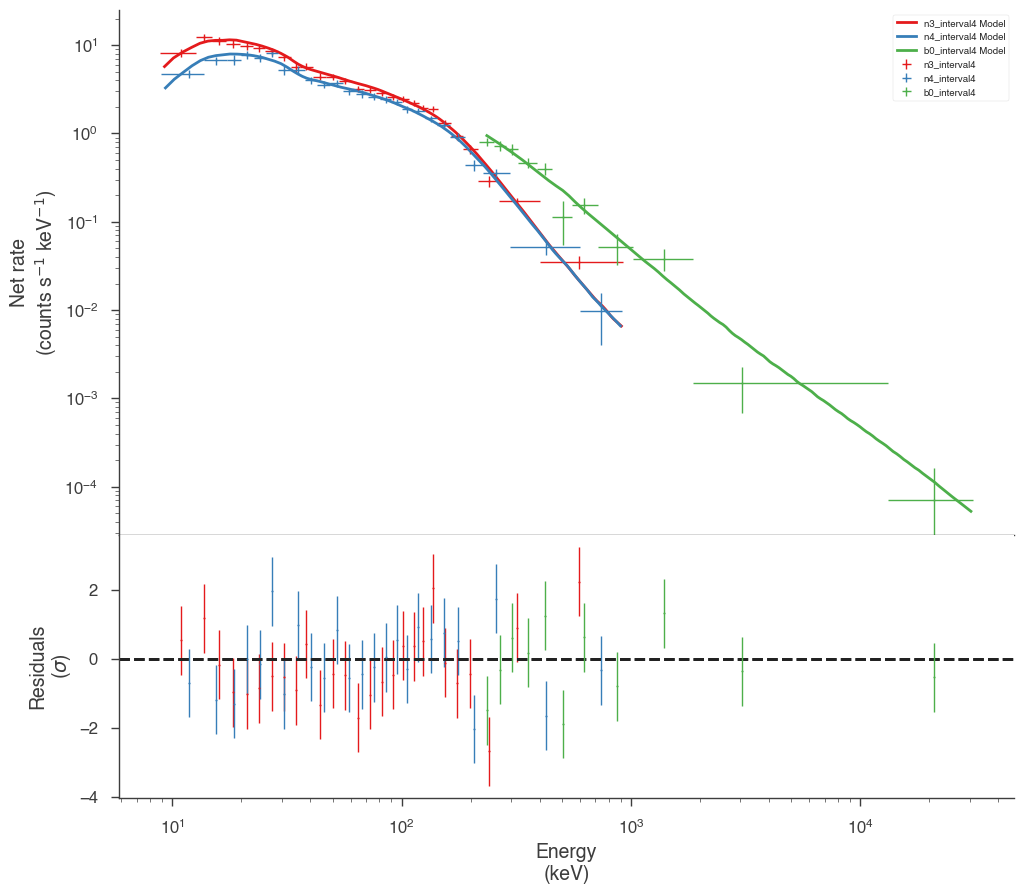

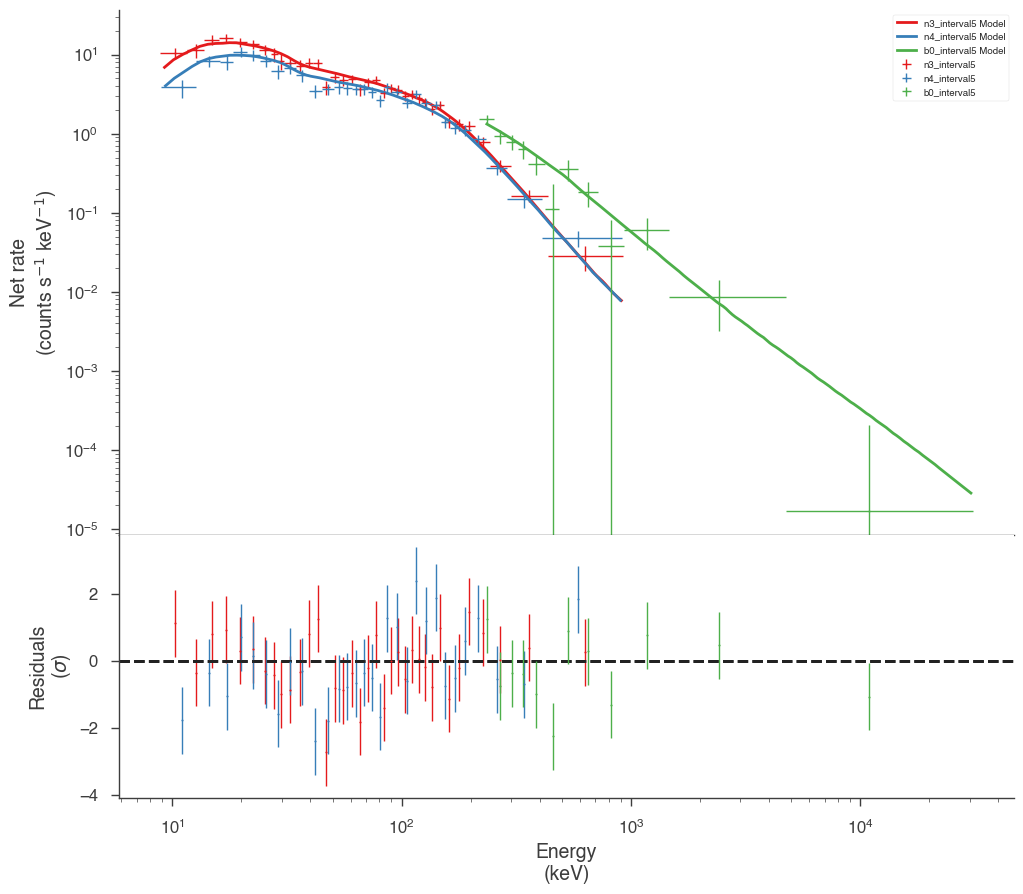

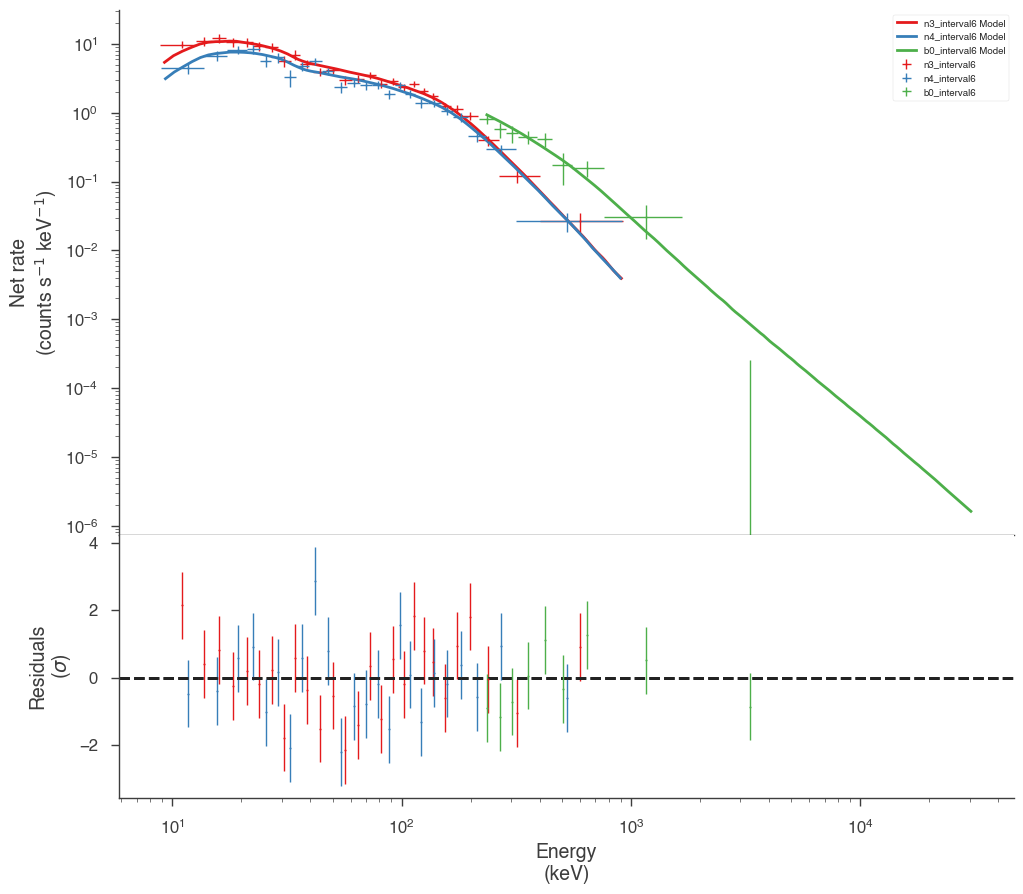

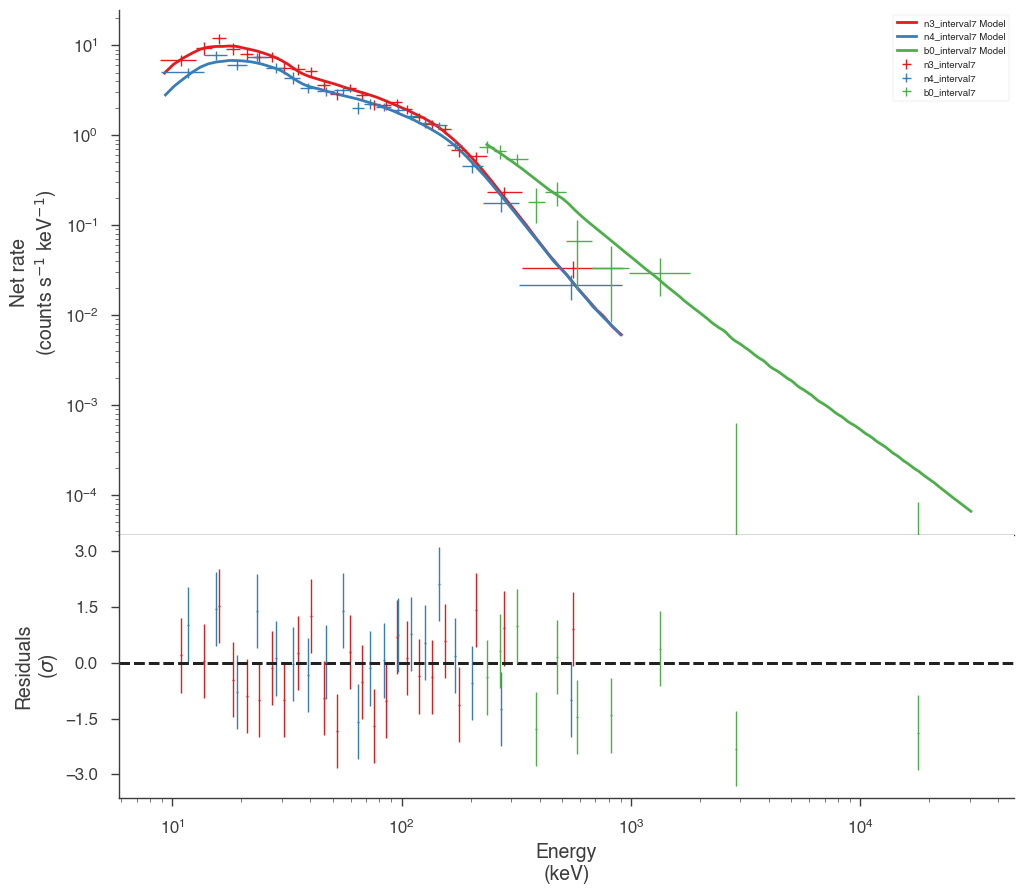

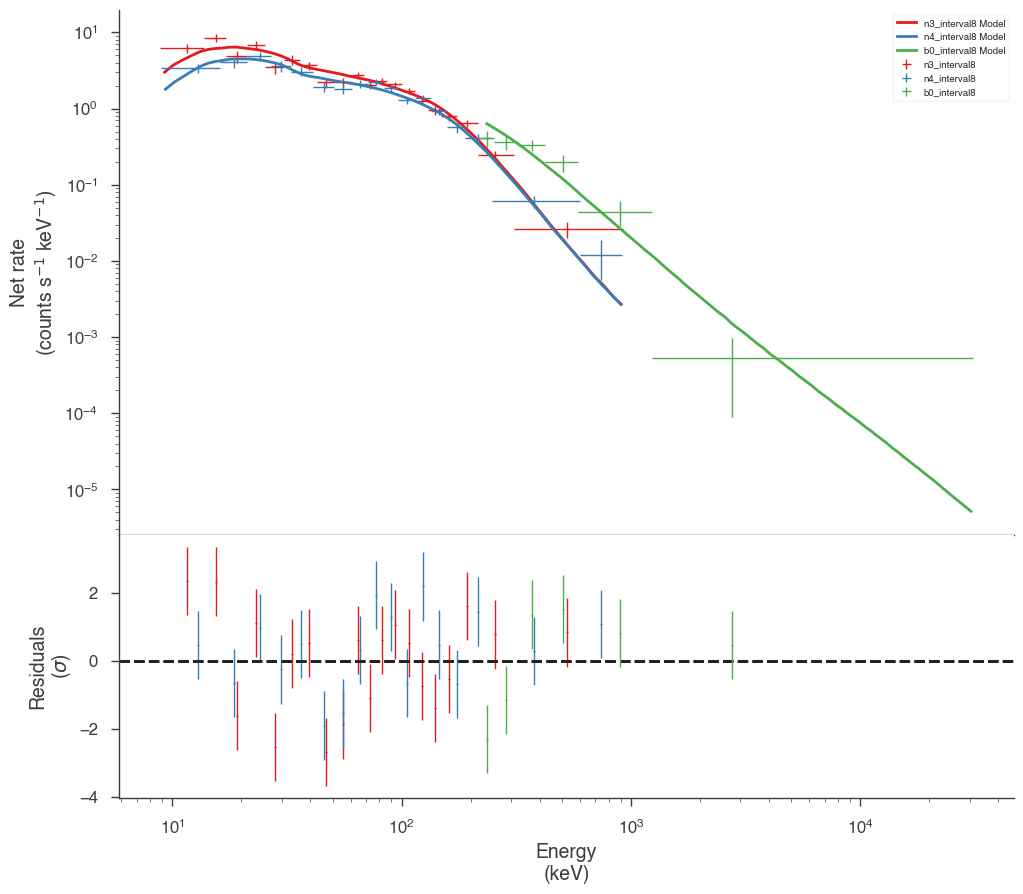

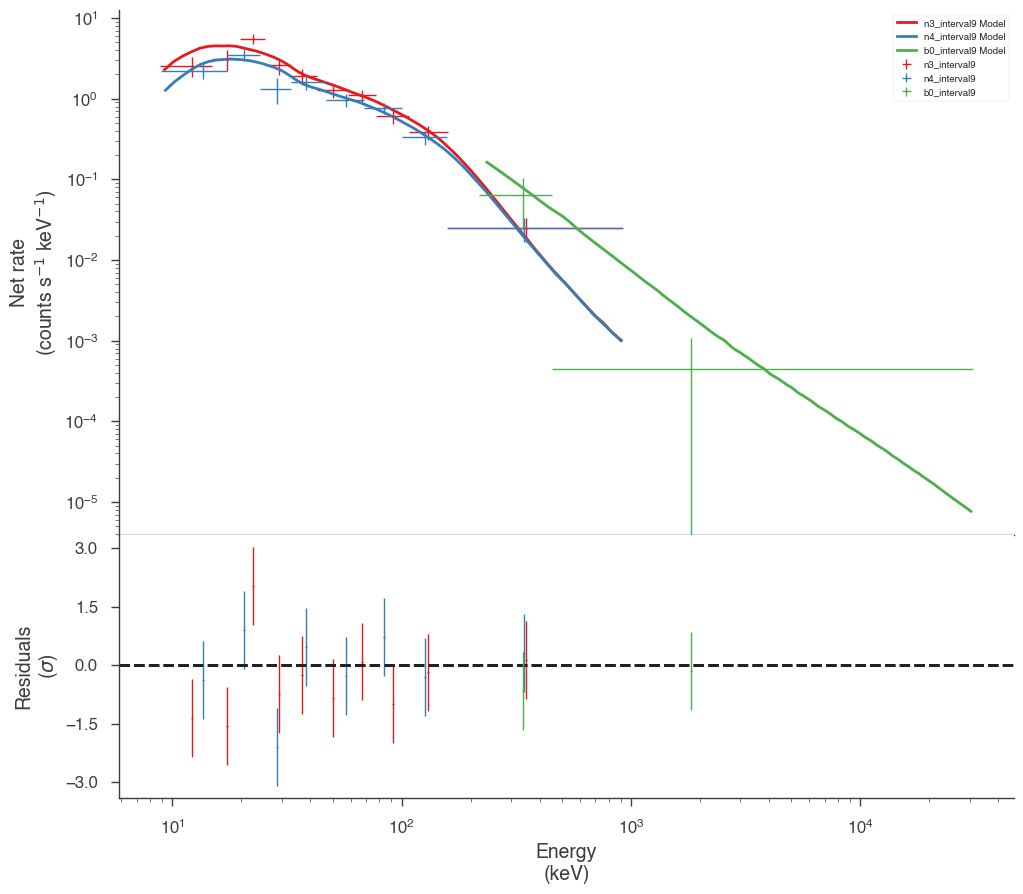

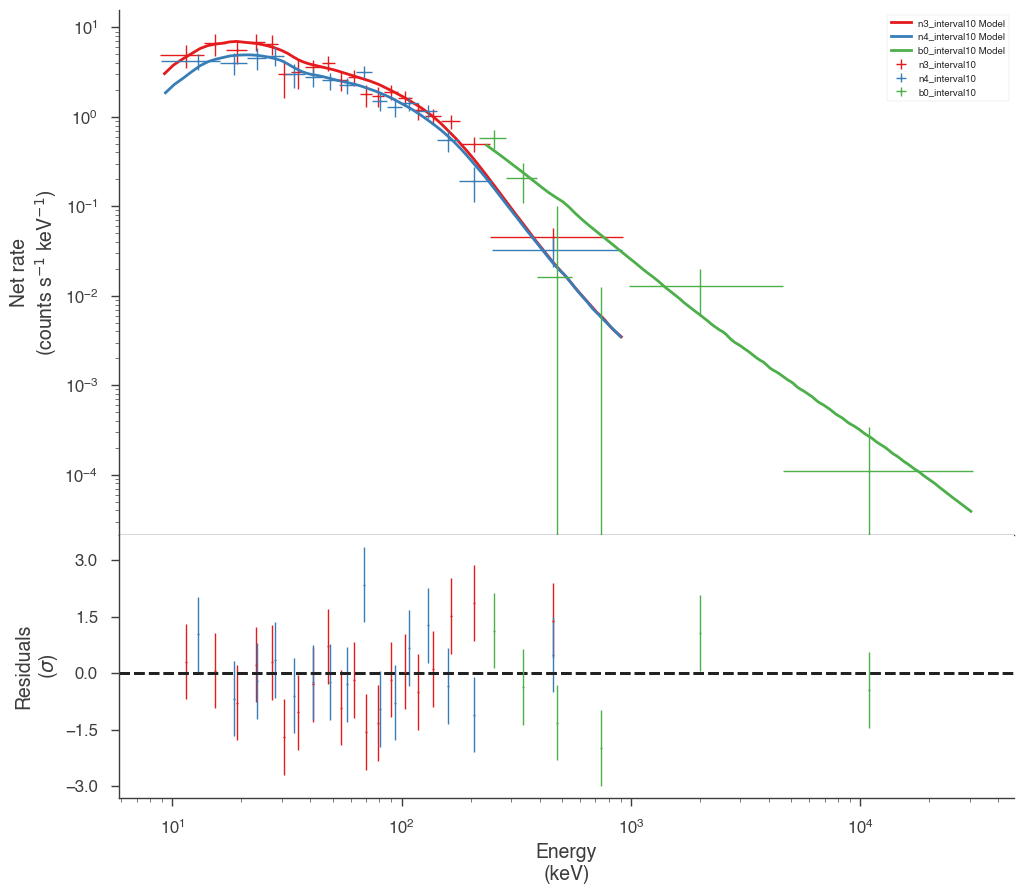

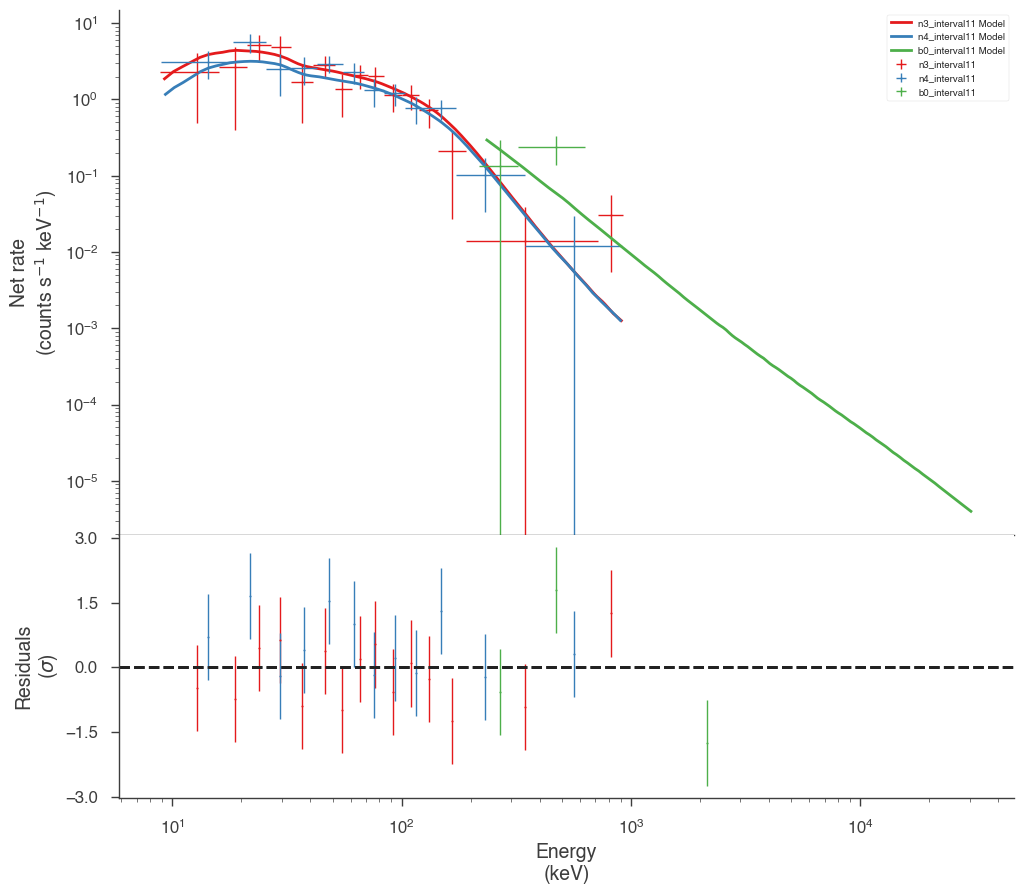

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

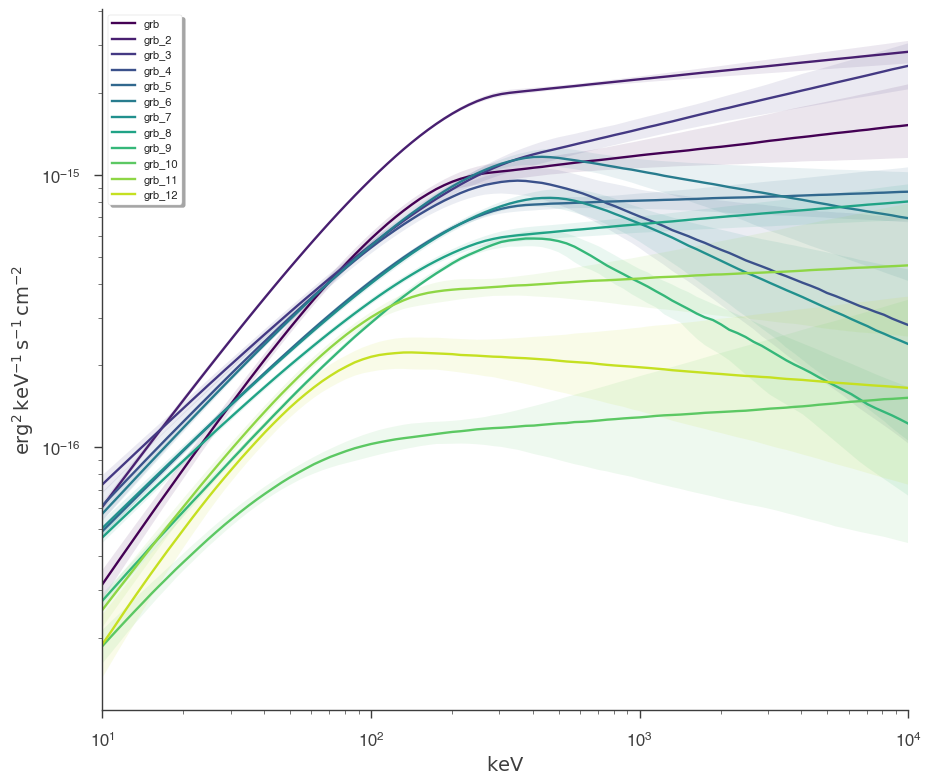

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.